In [5]:
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# plots
from wordcloud import WordCloud
import plotly
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Evaluation
from numpy import loadtxt

In [17]:
# Set up labels
labels = LabelEncoder().fit(['negative', 'positive'])

# Import supervised learning model predictions
y_pred_nb = np.load('./pred/y_predsNB.npy')
y_pred_svm = np.load('./pred/y_predsSVM.npy')

# Import supervised learning models test data
y_test = np.load('./Outputs/y_test.npy')


# Import deep learning predictions
y_preds_LSTM = np.load('./pred/y_predsLSTM.npy')
y_preds_LSTMreg = np.load('./pred/y_predsLSTMreg.npy')

# To output vector of labels for confusion matrix
y_preds_LSTM = np.argmax(y_preds_LSTM, axis=1)
y_preds_LSTMreg = np.argmax(y_preds_LSTMreg, axis=1)

# Import deep learning test data
Y_test = np.load('./Outputs/y_testLSTM.npy')
Y_test = np.argmax(Y_test, axis = 1)

print('Predictions and test data imported')



Predictions and test data imported


In [18]:
# Confusion Matrix helper function
plt.style.use(style='ggplot')
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

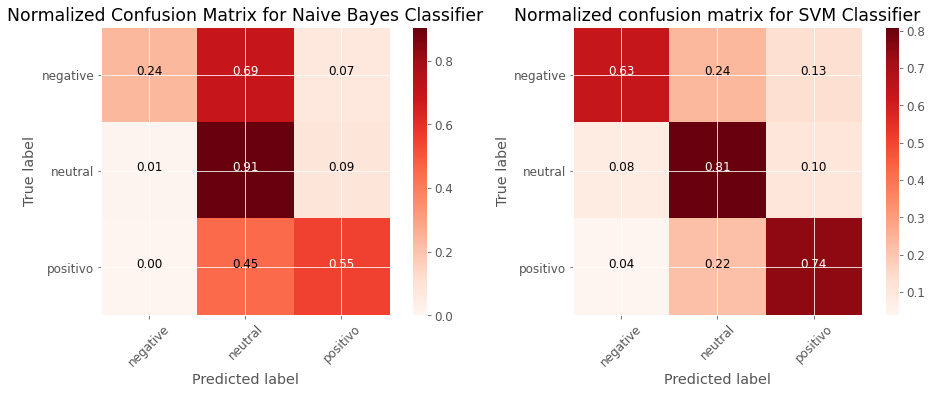

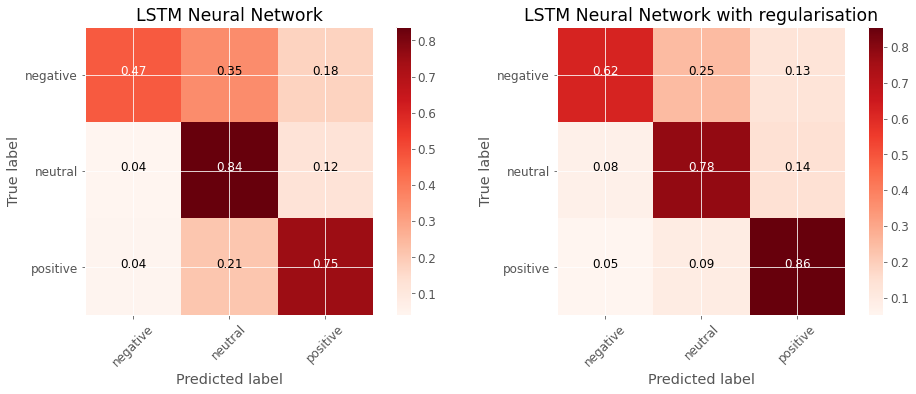

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
#--- Naive Bayes Classifier ---#

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_nb)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'neutral','positivo'], normalize=True,
                      title='Normalized Confusion Matrix for Naive Bayes Classifier')

#--- Support Vector Machine Classifier ---#

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig.add_subplot(3,3,2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'neutral', 'positivo'], normalize=True,
                      title='Normalized confusion matrix for SVM Classifier')

#--- LSTM Recurrent Neural Network ---#

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_preds_LSTM)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative','neutral', 'positive'], normalize=True,
                      title='LSTM Neural Network')

#--- LSTM Recurrent Neural Network with regularisation ---#

# Compute confusion matrix

cnf_matrix = confusion_matrix(Y_test, y_preds_LSTMreg)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig.add_subplot(3,3,2)
plot_confusion_matrix(cnf_matrix, classes=['negative','neutral', 'positive'], normalize=True,
                      title='LSTM Neural Network with regularisation')


In [20]:


# Helper function for Classification Report 

def classification_report_asdf(test, pred, output_dict=True):
  ''' ------------------------------
  Function to return a classification report 
  as dataframe, with rounded scores. 
  --- Parameters:----
  test = test data as array
  pred = prediction data array
  output_dic = set to True
  ------------------------
  '''
  # extract scores as dictionary
  report = classification_report(test,pred, output_dict=output_dict)
  df_report = pd.DataFrame(report).transpose()
  #round
  df_report[["precision","recall","f1-score"]]= df_report[["precision","recall","f1-score"]].apply(lambda x: round(x,2))
  df_report[["support"]]= df_report[["support"]].apply(lambda x: x.astype(np.int))
  # Add suport to avg
  df_report.loc['accuracy', 'support'] = df_report.loc['weighted avg', 'support']

  return df_report



In [14]:


# Classification reports for Supervised ML models

#--- Naive Bayes Classifier ----#
report_nb = classification_report_asdf(y_test, y_pred_nb)

#--- SVM Classifier ----#
report_svm = classification_report_asdf(y_test, y_pred_svm)

SML_dfs = [report_nb, report_svm]

SML_dfs_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in SML_dfs],
    keys=['Naive Bayes Classifier', 'SVM Classifier'],
    axis=1
)

# Show reports
SML_dfs_combined

Naive Bayes Classifier                         SVM Classifier  \
                          precision recall f1-score support      precision   
0                              0.95   0.24     0.38     152           0.71   
1                              0.60   0.91     0.72     354           0.76   
2                              0.76   0.55     0.64     243           0.76   
accuracy                       0.66   0.66     0.66     749           0.75   
macro avg                      0.77   0.57     0.58     749           0.74   
weighted avg                   0.72   0.66     0.63     749           0.75   

                                      
             recall f1-score support  
0              0.63     0.67     152  
1              0.81     0.79     354  
2              0.74     0.75     243  
accuracy       0.75     0.75     749  
macro avg      0.73     0.74     749  
weighted avg   0.75     0.75     749

In [21]:
# Classification report for RNN models

#---- LSTM Network ----#
report_LSTM = classification_report_asdf(Y_test, y_preds_LSTM)

#---- LSTM Network with regularisation ----#
report_LSTMreg = classification_report_asdf(Y_test, y_preds_LSTMreg)


#--- Add reports together ----#
RNN_dfs = [report_LSTM, report_LSTMreg]

RNN_dfs_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in RNN_dfs],
    keys=['LSTM Network', 'LSTM Network with regularisation'],
    axis=1
)

# Show reports
RNN_dfs_combined

LSTM Network                          \
                precision recall f1-score support   
0                    0.76   0.47     0.58     108   
1                    0.76   0.84     0.80     252   
2                    0.68   0.75     0.71     139   
accuracy             0.73   0.73     0.73     499   
macro avg            0.73   0.69     0.70     499   
weighted avg         0.74   0.73     0.73     499   

             LSTM Network with regularisation                          
                                    precision recall f1-score support  
0                                        0.72   0.62     0.67     108  
1                                        0.83   0.78     0.81     252  
2                                        0.70   0.86     0.77     139  
accuracy                                 0.77   0.77     0.77     499  
macro avg                                0.75   0.75     0.75     499  
weighted avg                             0.77   0.77     0.77     499